# Pixel Coordinate Predictor (50x50 grayscale)

This notebook trains a CNN to predict the `(x, y)` coordinates of the single bright pixel (value 255) in a 50x50 grayscale image where every other pixel is 0.

## How to run
- Python 3.10+.
- Install deps: `pip install torch torchvision matplotlib numpy`
- Run cells top to bottom. CPU is fine; a short training loop (<1 min) is used.

## Dataset rationale
- Each sample is procedurally generated: one pixel set to 1.0 (originally 255) at a random `(x, y)`; all others zero.
- This removes download needs and ensures uniform coverage of all coordinates.
- Targets are raw pixel indices (0-49 for x and y). Regression is used with `MSELoss`, which works well for continuous outputs and keeps the model simple.
- Train/val split is random to check generalization to unseen coordinates.



In [ ]:
import random
from dataclasses import dataclass
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

# Fixing random seeds so runs are reproducible
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Pick CPU or GPU depending on availability ( I utilized CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# hyperparameters and image size
IMG_SIZE = 50
TOTAL_SAMPLES = 4000
VAL_RATIO = 0.2
BATCH_SIZE = 64
EPOCHS = 8
LR = 1e-3


def make_sample() -> Tuple[np.ndarray, np.ndarray]:
    """Creates one 50x50 image with a single bright pixel and its (x, y) label."""
    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    x = np.random.randint(0, IMG_SIZE)
    y = np.random.randint(0, IMG_SIZE)
    img[y, x] = 1.0  # scale 255 -> 1.0 for stable training
    target = np.array([float(x), float(y)], dtype=np.float32)
    return img, target


# Dataset wrapper around pre-generated samples
class PixelDataset(Dataset):
    def __init__(self, samples: List[Tuple[np.ndarray, np.ndarray]]):
        self.samples = samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        img, target = self.samples[idx]
        # dimension for CNN: (1, H, W)
        return torch.from_numpy(img).unsqueeze(0), torch.from_numpy(target)


# Build full dataset once so train/val share the same distribution
all_samples = [make_sample() for _ in range(TOTAL_SAMPLES)]
dataset = PixelDataset(all_samples)
val_size = int(len(dataset) * VAL_RATIO)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
print(f"Train size: {train_size}, Val size: {val_size}")


Train size: 3200, Val size: 800


In [ ]:
# Defining a small CNN that regresses directly to (x, y)
class CoordNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        return self.head(self.features(x))


# Instantiate model, loss, and optimizer
model = CoordNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)


CoordNet(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
# Store per-epoch training and validation losses
@dataclass
class EpochLog:
    epoch: int
    train_loss: float
    val_loss: float


def run_epoch(data_loader, train_mode: bool):
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss, total_items = 0.0, 0
    for imgs, targets in data_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        with torch.set_grad_enabled(train_mode):
            preds = model(imgs)
            loss = criterion(preds, targets)
            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        batch_size = targets.size(0)
        total_loss += loss.item() * batch_size
        total_items += batch_size
    return total_loss / max(total_items, 1)


# Training the model for a fixed number of epochs
def train_model(epochs: int) -> List[EpochLog]:
    history: List[EpochLog] = []
    for epoch in range(1, epochs + 1):
        train_loss = run_epoch(train_loader, train_mode=True)
        val_loss = run_epoch(val_loader, train_mode=False)
        history.append(EpochLog(epoch, train_loss, val_loss))
        print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")
    return history


# Runs training and capture the history
history = train_model(EPOCHS)


Epoch 01 | train 385.0789 | val 211.4270
Epoch 02 | train 167.7294 | val 40.4448
Epoch 03 | train 24.1297 | val 14.8354
Epoch 04 | train 10.1388 | val 8.2282
Epoch 05 | train 6.3238 | val 5.1570
Epoch 06 | train 3.9340 | val 3.0934
Epoch 07 | train 2.5822 | val 1.9549
Epoch 08 | train 1.8522 | val 1.4609


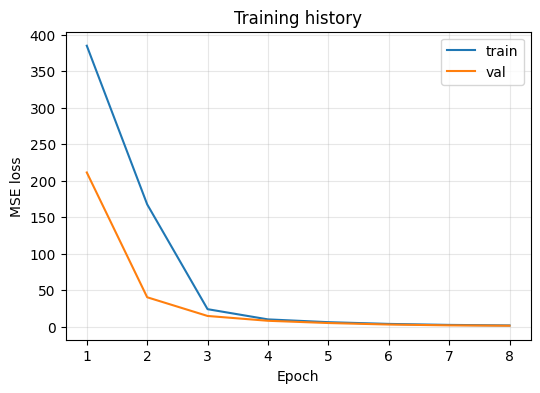

In [ ]:
# Plot training and validation loss curves
def plot_history(logs: List[EpochLog]):
    epochs = [log.epoch for log in logs]
    train_losses = [log.train_loss for log in logs]
    val_losses = [log.val_loss for log in logs]

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="train")
    plt.plot(epochs, val_losses, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Training history")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


plot_history(history)


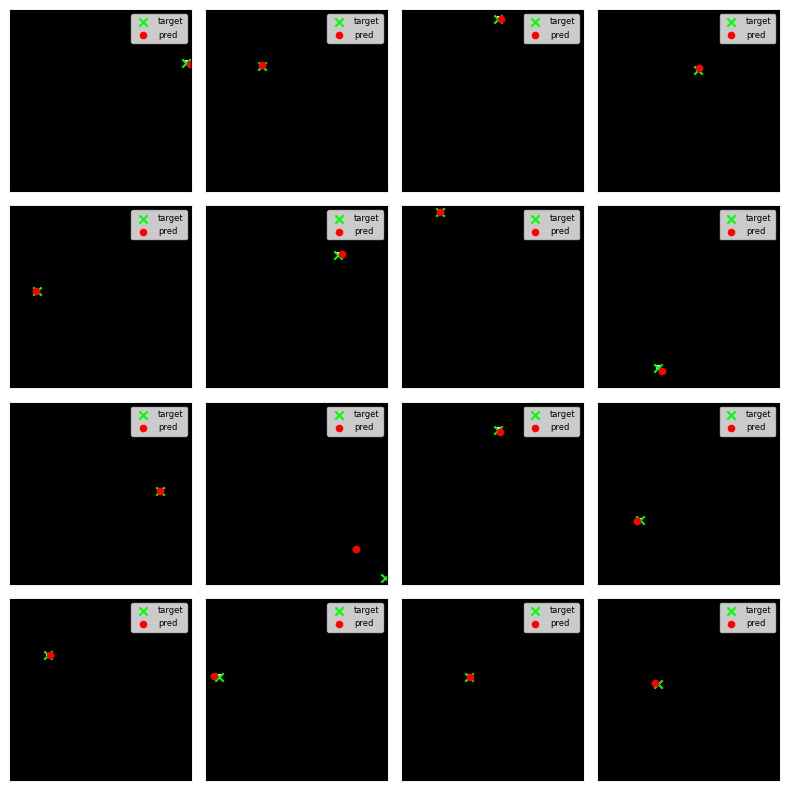

In [6]:
# Visualise a small batch with predicted and true coordinates
def evaluate_sample_batch(loader, max_samples: int = 16):
    model.eval()
    imgs, targets = next(iter(loader))
    imgs = imgs.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        preds = model(imgs)
    imgs = imgs.cpu().numpy()
    targets = targets.cpu().numpy()
    preds = preds.cpu().numpy()

    take = min(max_samples, len(imgs))
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()
    for i in range(take):
        ax = axes[i]
        ax.imshow(imgs[i][0], cmap="gray")
        ax.scatter(
            targets[i][0],
            targets[i][1],
            marker="x",
            color="lime",
            label="target",
        )
        ax.scatter(
            preds[i][0],
            preds[i][1],
            marker="o",
            color="red",
            s=20,
            label="pred",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(loc="upper right", fontsize=6)
    plt.tight_layout()
    plt.show()


# Draw a grid of predictions on validation data
evaluate_sample_batch(val_loader)



In [11]:
# Compute average MSE and MAE on a data loader
def evaluate_metrics(loader):
    model.eval()
    mse_total, mae_total, count = 0.0, 0.0, 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            preds = model(imgs)
            batch_size = targets.size(0)
            mse_total += (
                nn.functional.mse_loss(
                    preds,
                    targets,
                    reduction="mean",
                ).item()
                * batch_size
            )
            mae_total += (
                nn.functional.l1_loss(
                    preds,
                    targets,
                    reduction="mean",
                ).item()
                * batch_size
            )
            count += batch_size
    return mse_total / max(count, 1), mae_total / max(count, 1)


# Evaluate the model on the validation set
val_mse, val_mae = evaluate_metrics(val_loader)
print(f"Val MSE: {val_mse:.4f}, Val MAE (pixels): {val_mae:.4f}")


Val MSE: 0.3951, Val MAE (pixels): 0.4352


## Notes and possible extensions
- Try a slightly deeper CNN or add coordinate normalization to `[0,1]` to make the target scale independent of image size.
- Increase `TOTAL_SAMPLES` or `EPOCHS` for tighter convergence; the defaults keep runtime short.
- Swap `MSELoss` for `SmoothL1Loss` if you prefer reduced sensitivity to outliers.
